# Celestial mechanics with the `celmech` code

**Sam Hadden** (CITA)

Collaborators: **Dan Tamayo** (Princeton), **David Hernandez** (CfA)



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sympy import init_printing
init_printing()

# What is `celmech`?

- Code for celestial mechanics calculations
    - Calculate disturbing function expansion
    - Construct, manipulate, and integrate Hamiltonian equations of motion
    - Much more...
- Developed mainly in `python`
- Designed to work with the [`rebound`](https://github.com/hannorein/rebound) N-body code (Rein & Liu 2012)
- Symbolic mathematics with [`sympy`](https://www.sympy.org/en/index.html) (Meurer et. al. 2017)

# Where is `celmech`?

- PyPI: ``pip install celmech``
- GitHub reposity at [github.com/shadden/celmech](https://github.com/shadden/celmech) 
    - Includes lots of Jupyter notebook examples
- Documentation at [celmech.readthedocs.io](https://celmech.readthedocs.io)
- This notebook is available on [GitHub](https://github.com/shadden/)!

# An example
A system of two Earth-mass planets near a 3:2 mean motion resonance

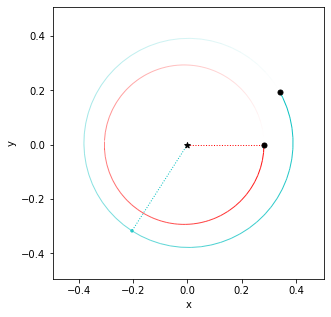

In [2]:
import rebound
rebound_sim = rebound.Simulation()
rebound_sim.add(m=1)
rebound_sim.add(m=3e-6,P = 1, e = 0.04)
rebound_sim.add(m=3e-6,P = 3 / 2, e = 0.02,l=0.5,pomega = np.pi+1)
rebound.OrbitPlot(rebound_sim,color=True,periastron=True);

In [3]:
sim2=rebound_sim.copy()

# Initializing a ``celmech`` model 
- Create `Poincare` and `PoincareHamiltonian` instances
- Initialize directly from a ``rebound`` simulation

In [4]:
from celmech import Poincare, PoincareHamiltonian
poincare_particles = Poincare.from_Simulation(rebound_sim)
Hp = PoincareHamiltonian(poincare_particles)

# The ``Poincare`` class 
- Represents system in terms of canonical variable pairs:
 $$\begin{align}
 \Lambda_i&= \mu_i\sqrt{GM_ia_i} ~;~ \lambda_i \\
 (\eta_i,\kappa_i)&\approx \sqrt{\Lambda_i}e_i \times(-\sin\varpi_i,\cos\varpi_i)\\
  (\rho_i,\sigma_i)&\approx \sqrt{\Lambda_i}\sin(I_i/2) \times(-\sin\Omega_i,\cos\Omega_i)\\
 \end{align}$$

In [5]:
type(poincare_particles)

celmech.poincare.Poincare

In [6]:
qp_pairs = poincare_particles.qp_pairs
qp_pairs

[(λ₁, Λ₁), (η₁, κ₁), (ρ₁, σ₁), (λ₂, Λ₂), (η₂, κ₂), (ρ₂, σ₂)]

# The ``Poincare`` class 
- Stores numerical values of canonical variables

In [11]:
Lambda1 = qp_pairs[0][1]
Lambda1, poincare_particles.qp[Lambda1]

(Λ₁, 1.625772780575234e-06)

- Also provides orbital mass, orbital elements, etc.

In [13]:
G = poincare_particles.G
particle = poincare_particles.particles[1]
particle.mu * np.sqrt(G * particle.M * particle.a)

1.625772780575234e-06

# The ``PoincareHamiltonian`` class 
- Represents a planetary system's Hamiltonian


In [14]:
type(Hp)

celmech.poincare.PoincareHamiltonian

- The ``H`` attribute stores the symbolic Hamiltonian
    - Upon intialization just Keplerian terms

In [15]:
Hp.H

   2   2   3    2   2   3
  G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ──────────
        2            2   
    2⋅Λ₂         2⋅Λ₁    

 - Or, in orbital elements: 
 $$
 -\frac{Gm_*m_1}{2a_1}-\frac{Gm_*m_2}{2a_2}
 $$

# The ``PoincareHamiltonian`` class 
- Stores numerical values of symbolic parameters as well

In [20]:
Hp.N_H

  1.34999595001215e-17   1.34999595001215e-17
- ──────────────────── - ────────────────────
            2                      2         
          Λ₂                     Λ₁          

# Building a Hamiltonian
- Users build up a Hamiltonian by selecting and adding disturbing function terms
- ``PoincareHamiltonian`` includes an extensive interface for specifying and adding terms
- We'll add terms for the 3:2 MMR

In [11]:
Hp.add_MMR_terms(p=3,q=1,max_order=1,indexIn=1,indexOut=2)

- The symbolic Hamiltonian is updated with the newly-added terms

In [12]:
Hp.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                                  
───── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\
____       _______________ ⎟                                                  
,0}      ╲╱ \Lambda_{1,0}  ⎠                                                  
──────────────────────────── - ───────────────────────────────────────────────
                                                   

# Building a Hamiltonian
- Equivalent in terms of orbital elements:

In [13]:
Hp.df

<IPython.core.display.Math object>

# Integrating Hamilton's equations
 - Equations of motion automatically generated from the Hamiltonian
 - Integration and particle interface designed to mirror ``rebound``

In [14]:
rebound_particles = rebound_sim.particles
celmech_particles = Hp.particles

# times to save output
times = np.linspace(0,500 * rebound_particles[1].P,100)

# Arrays to store results
eIn_rebound,eIn_celmech = np.zeros((2,100))

# Main integration loop
for i,t in enumerate(times):
    rebound_sim.integrate(t)
    Hp.integrate(t)
    # save eccentricity of inner planet
    eIn_rebound[i] = rebound_particles[1].e
    eIn_celmech[i] = celmech_particles[1].e
    

# Comparing $N$-body and ``celmech``
- The simple ``celmech`` model shows fair agreement with direct $N$-body integration

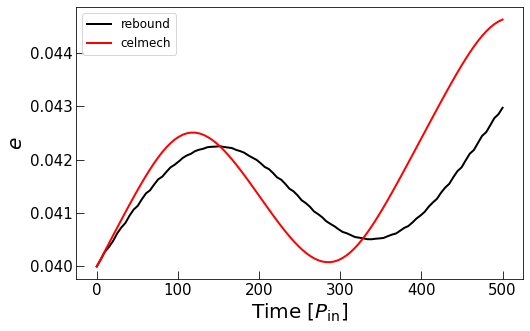

In [15]:
fig,ax = plt.subplots(1,sharex=True,figsize=(8,5))
plt.tick_params(labelsize=15,direction='in',size=8)
ax.plot(times,eIn_rebound,color='k',lw=2,label='rebound')
ax.plot(times,eIn_celmech,color='r',lw=2,label='celmech')
ax.set_ylabel(r"$e$",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20);

# Making a more accurate ``celmech`` model
Now we'll include:
- Secular terms up to 2nd order in planets' eccentricities
- 3:2 resonant terms up to 3rd order in planets' eccentricities

In [16]:
pvars = Poincare.from_Simulation(sim2)
Hp = PoincareHamiltonian(pvars)

In [17]:
Hp.add_secular_terms(max_order=2,indexIn=1,indexOut=2,inclinations=False)
Hp.add_MMR_terms(p=3,q=1,max_order=3,indexIn=1,indexOut=2,inclinations=False)

# Terms included in the improved model
Many more disturbing function terms are now included:

- Secular terms:
$$
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(0,0,0,0,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_2^2
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(0,0,0,0,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^2
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(0,0,-1,1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2\cos(-\varpi_1+\varpi_2)
$$

# ...

- 6:4 terms:
$$
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(6,-4,0,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_2^2\cos(6\lambda_2-4\lambda_1-2\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(6,-4,-1,-1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2\cos(6\lambda_2-4\lambda_1-\varpi_1-\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(6,-4,-2,0,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2\cos(6\lambda_2-4\lambda_1-2\varpi_1)
$$

# ...
- 9:6 terms:
$$
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(9,-6,0,-3,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_2^3\cos(9\lambda_2-6\lambda_1-3\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(9,-6,-1,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2^2\cos(9\lambda_2-6\lambda_1-\varpi_1-2\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(9,-6,-2,-1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2e_2\cos(9\lambda_2-6\lambda_1-2\varpi_1-\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(9,-6,-3,0,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^3\cos(9\lambda_2-6\lambda_1-3\varpi_1)
$$

# ...
- 3rd order 3:2 terms:
$$
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(3,-2,0,-1,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_2^3\cos(3\lambda_2-2\lambda_1-\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(3,-2,0,-1,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^2e_2\cos(3\lambda_2-2\lambda_1-\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(3,-2,-1,0,0,0)}^{(0,0,0,1)}(\alpha_{1,2})e_1e_2^2\cos(3\lambda_2-2\lambda_1-\varpi_1)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(3,-2,-1,0,0,0)}^{(0,0,1,0)}(\alpha_{1,2})e_1^3\cos(3\lambda_2-2\lambda_1-\varpi_1)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(3,-2,1,-2,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1e_2^2\cos(3\lambda_2-2\lambda_1+\varpi_1-2\varpi_2)\\
-\frac{Gm_1m_2}{a_{2,0}}\tilde{C}_{(3,-2,-2,1,0,0)}^{(0,0,0,0)}(\alpha_{1,2})e_1^2e_2\cos(3\lambda_2-2\lambda_1-2\varpi_1+\varpi_2)
$$

These terms would be tedious to add by hand...

In [18]:
from celmech.lie_transformations import FirstOrderGeneratingFunction
chi = FirstOrderGeneratingFunction(pvars)
chi.add_zeroth_order_term(indexIn=1,indexOut=2)
chi.add_MMR_terms(2,1,indexIn=1,indexOut=2)
chi.add_MMR_terms(4,1,indexIn=1,indexOut=2)
chi.osculating_to_mean()

In [19]:
rebound_particles = sim2.particles
celmech_particles = Hp.particles
times = np.linspace(0,500 * rebound_particles[1].P,100)
eIn_rebound,eIn_celmech = np.zeros((2,100))
thetaIn_rebound,thetaIn_celmech = np.zeros((2,100))
energy = np.zeros(100)
for i,t in enumerate(times):
    sim2.integrate(t)
    Hp.integrate(t)
    energy[i] = Hp.calculate_energy()
    eIn_rebound[i] = rebound_particles[1].e
    eIn_celmech[i] = celmech_particles[1].e
    
    thetaIn_rebound[i] = -2*rebound_particles[1].l + 3*rebound_particles[2].l - rebound_particles[1].pomega
    thetaIn_celmech[i] = -2*celmech_particles[1].l + 3*celmech_particles[2].l - celmech_particles[1].pomega

# Improved agreement with higher order model
The higher-order model now shows excellent agreement with $N$-body

Text(0.5, 0, 'Time [$P_\\mathrm{in}$]')

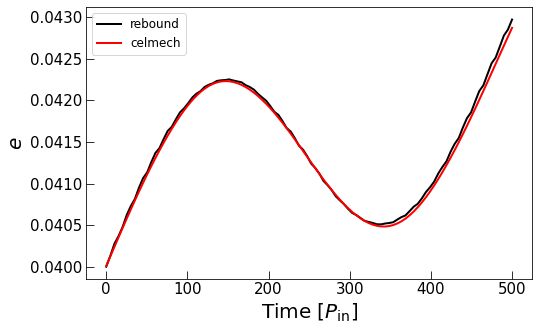

In [20]:
fig,ax = plt.subplots(1,sharex=True,figsize=(8,5))
plt.tick_params(labelsize=15,direction='in',size=8)
ax.plot(times,eIn_rebound,color='k',lw=2,label='rebound')
ax.plot(times,eIn_celmech,color='r',lw=2,label='celmech')
ax.set_ylabel(r"$e$",fontsize=20)
ax.legend(fontsize=12)
ax.set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20)

Text(0.5, 0, 'Time [$P_\\mathrm{in}$]')

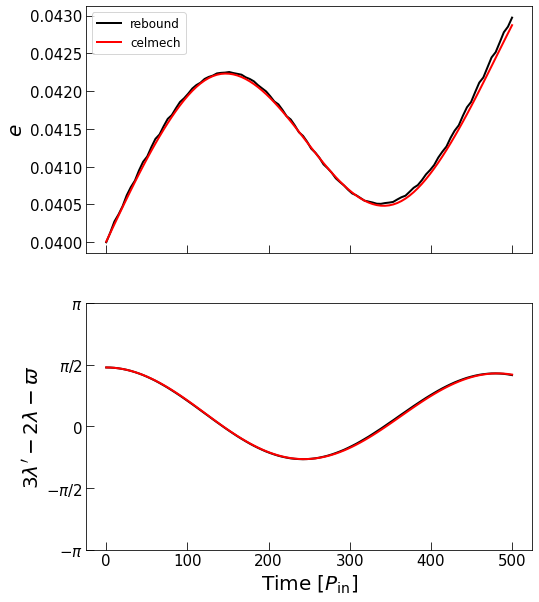

In [21]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(8,10))
for a in ax:
    plt.sca(a)
    plt.tick_params(labelsize=15,direction='in',size=8)
wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi)-np.pi
thetaIn_rebound = wrap2pi(thetaIn_rebound)
thetaIn_celmech = wrap2pi(thetaIn_celmech)

ax[0].plot(times,eIn_rebound,color='k',lw=2,label='rebound')
ax[0].plot(times,eIn_celmech,color='r',lw=2,label='celmech')
ax[0].set_ylabel(r"$e$",fontsize=20)
ax[0].legend(fontsize=12)


ax[1].plot(times,thetaIn_rebound,color='k',lw=2,label='rebound')
ax[1].plot(times,thetaIn_celmech,color='r',lw=2,label='celmech')
ax[1].set_ylim(-np.pi,np.pi)
ax[1].set_yticks([-np.pi,-0.5*np.pi,0,0.5*np.pi,np.pi])
ax[1].yaxis.set_ticklabels([r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
ax[1].set_ylabel(r"$3\lambda'-2\lambda-\varpi$",fontsize=20)
ax[1].set_xlabel(r"Time [$P_\mathrm{in}$]",fontsize=20)

# Basic principles
 - $N$-body codes like `rebound` integrate equations of motion directly:
    $$
    \dot{\mathbf{r}}_i = \frac{1}{m_i}\mathbf{p_i}\\
    \dot{\mathbf{p}}_i = -\sum_{i\ne j}Gm_im_j\frac{(\mathbf{r}_i - \mathbf{r}_j)}{|\mathbf{r}_i - \mathbf{r}_j|^3}
    $$
 - `celmech` works with approximate equations of motion.
     - Derived from disturbing function expansion of Hamiltonian in powers of $e$ and $I$
     - Equations formulated in canonical "action-angle" variables

# Basic principles (con't.)
The Hamiltonian is (e.g., [Laskar & Robutel 1995](https://ui.adsabs.harvard.edu/abs/1995CeMDA..62..193L/abstract)):

$$
H =  
{\sum_{i=1}^{N-1}H_{\mathrm{Kep},i}}
+ 
{\sum_{i=1}^{N-1} \sum_{j=1}^{i}
H_{\mathrm{int.}}^{(i,j)}}
$$ 
where 
$H_{\mathrm{Kep},i}= \frac{1}{2}\frac{|\tilde{\mathbf{r}}_i|^2}{\mu_i}   - \frac{GM_*m_i}{|\mathbf{r}_i|} = -\frac{GM_*m_i}{2a_i}$ 

and $$H_{\mathrm{int.}}^{(i,j)}={-\frac{Gm_im_j}{|\mathbf{r}_i - \mathbf{r}_j|}} + {\frac{{\mathbf{p}}_i \cdot {\mathbf{p}}_j }{M_*}}$$
      

# Basic principles (con't.)
- Expand interaction Hamiltonian as a cosine series

$$
        -\frac{Gm_im_j}{|\mathbf{r}_i - \mathbf{r}_j |} +\frac{1}{m_*}\mathbf{p}_i\cdot\mathbf{p}_j= 
        -\frac{Gm_im_j}{a_j}
        \sum_{\bf k}
          S_\mathbf{k}(a_i/a_j,e_i,e_i,I_i,I_j)\cos(k_1\lambda_j + k_2\lambda_i - k_3\varpi_i - k_4 \varpi_j - k_5\Omega_i - k_6\Omega_j)
$$

- Then exapnd cosine coefficients, $S_\mathbf{k}$, in powers of eccentricity and inclination:

$$
 S_\mathbf{k}= \sum_{\nu_1,\nu_2,\nu_3,\nu_4=0}^\infty 
          \tilde{C}_{\bf k}^{\pmb{
         \nu}}(a_i/a_j)\sin(I_i/2)^{|k_5|+2\nu_1}\sin(I_j/2)^{|k_6|+2\nu_2}e_i^{|k_3|+2\nu_3}e_j^{|k_4|+2\nu_4}
$$

# General framework
In canonical heliocentric variables (e.g., Laskar & Robutel 1995), the Hamiltonian
is
$$
\begin{eqnarray}
        H &=& 
        \underbrace{\sum_{i=1}^{N-1}H_{\mathrm{Kep},i}}_{\mathrm{big}}
        + 
        \underbrace{\sum_{i=1}^{N-1} \sum_{j=1}^{i} H_{\mathrm{int.}}^{(i,j)}}_{\mathrm{small}}
\end{eqnarray}
$$
where
$$
    \begin{eqnarray}
H_{\mathrm{Kep},i} 
    &=& 
    \frac{1}{2}\frac{|\tilde{\pmb{r}}_i|^2}{\mu_i}   - \frac{GM_i\mu_i}{|\pmb{r}_i|} 
\\
H_{\mathrm{int.}}^{(i,j)} 
&=&
\underbrace{-\frac{Gm_im_j}{|\pmb{r}_i - \pmb{r}_j|}}_{\mathrm{direct}} + 
\underbrace{\frac{\tilde{\pmb{r}}_i \cdot \tilde{\pmb{r}}_j }{M_*}}_{\mathrm{indirect}}
\end{eqnarray}
$$

# The disturbing function

$$
        -\frac{Gm_im_j}{|\mathbf{r}_i - \mathbf{r}_j |} +\frac{1}{m_*}\mathbf{p}_i\cdot\mathbf{p}_j= 
        -\frac{Gm_im_j}{a_j}
        \sum_{\bf k}
          S_\mathbf{k}(a_i/a_j,e_i,e_i,I_i,I_j)\cos(k_1\lambda_j + k_2\lambda_i - k_3\varpi_i - k_4 \varpi_j - k_5\Omega_i - k_6\Omega_j)
$$
Then exapnd $S_\mathbf{k}$ in powers of eccentricity and inclination:
$$
 S_\mathbf{k}= \sum_{\nu_1,\nu_2,\nu_3,\nu_4=0}^\infty 
          \tilde{C}_{\bf k}^{\pmb{
         \nu}}(a_i/a_j)\sin(I_i/2)^{|k_5|+2\nu_1}\sin(I_j/2)^{|k_6|+2\nu_2}e_i^{|k_3|+2\nu_3}e_j^{|k_4|+2\nu_4}
$$

In [18]:
Lambda1,Lambda2 = poincare_particles.qp_vars[6],poincare_particles.qp_vars[9]

In [20]:
list(enumerate(Hp.H_params.keys()))

[(0, G), (1, μ₁), (2, m₁), (3, M₁), (4, \Lambda_{1,0}), (5, a_{1,0}), (6, \alp
ha_{1,2}), (7, μ₂), (8, m₂), (9, M₂), (10, \Lambda_{2,0}), (11, a_{2,0})]

In [30]:
G,mu1,m1,M1,mu2,m2,M2 = [list(enumerate(Hp.H_params.keys()))[i][1] for i in (0,1,2,3,7,8,9)]

In [24]:
import sympy as sp

In [38]:
a1,a2=sp.symbols("a(1:3)")
mstar = sp.symbols("M_*")

In [37]:
mstar

m_*

In [32]:
rule

⎧         _________           _________⎫
⎨Λ₁: μ₁⋅╲╱ G⋅M₁⋅a₁ , Λ₂: μ₂⋅╲╱ G⋅M₂⋅a₂ ⎬
⎩                                      ⎭

In [42]:
rule = {Lambda1:mu1*sp.sqrt(G*M1*a1) ,Lambda2:mu2*sp.sqrt(G*M2*a2)}
mass_rule={M1:m1+mstar,M2:m2+mstar,mu1:m1*mstar/(m1 + mstar),mu2:m2*mstar/(m2 + mstar)}

In [44]:
rule

⎧         _________           _________⎫
⎨Λ₁: μ₁⋅╲╱ G⋅M₁⋅a₁ , Λ₂: μ₂⋅╲╱ G⋅M₂⋅a₂ ⎬
⎩                                      ⎭

In [45]:
mass_rule

⎧                                 M_*⋅m₁        M_*⋅m₂ ⎫
⎨M₁: M_* + m₁, M₂: M_* + m₂, μ₁: ────────, μ₂: ────────⎬
⎩                                M_* + m₁      M_* + m₂⎭

In [47]:
Hp.H.subs(rule).subs(mass_rule)

  G⋅M_*⋅m₂   G⋅M_*⋅m₁
- ──────── - ────────
    2⋅a₂       2⋅a₁  

In [43]:
rule , Hp.H.subs(rule)

⎛⎧         _________           _________⎫    G⋅M₁⋅μ₁   G⋅M₂⋅μ₂⎞
⎜⎨Λ₁: μ₁⋅╲╱ G⋅M₁⋅a₁ , Λ₂: μ₂⋅╲╱ G⋅M₂⋅a₂ ⎬, - ─────── - ───────⎟
⎝⎩                                      ⎭      2⋅a₁      2⋅a₂ ⎠